<a href="https://colab.research.google.com/github/chigvintseva/UniProject-simulation-techniques/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data generation**

In [337]:
import numpy as np
import pandas as pd
import simpy
from scipy import stats

1. Set random seed for reproducibility

In [338]:
# to ensure the reproducable synthetic data generation
np.random.seed(42)

2. Generate patient arrival times using poisson process

In [339]:
arrival_rate_per_hour = 40
simulation_duration_hours = 24

#total patient count
num_patients = np.random.poisson(lam=arrival_rate_per_hour * simulation_duration_hours)

In [340]:
#inter-arrival times (in hours) from exponential distribution
inter_arrival_times = np.random.exponential(scale=1/arrival_rate_per_hour, size=num_patients)

In [341]:
#cumulative arrival times
arrival_times = np.cumsum(inter_arrival_times)

Arrivals example for data verfification:

In [342]:
print("Sample of Patient Arrival Times:")
for i, arrival in enumerate(arrival_times[:5], start=1):
    hours = int(arrival)
    minutes = int((arrival - hours) * 60)
    print(f"  Patient {i}: {hours} hours and {minutes} minutes after simulation start")

Sample of Patient Arrival Times:
  Patient 1: 0 hours and 1 minutes after simulation start
  Patient 2: 0 hours and 3 minutes after simulation start
  Patient 3: 0 hours and 3 minutes after simulation start
  Patient 4: 0 hours and 3 minutes after simulation start
  Patient 5: 0 hours and 3 minutes after simulation start


3. Assign Triage Categories with Weighted Sampling

In [343]:
# triage levels and their empirical probabilities
triage_levels = [1, 2, 3, 4, 5]
triage_probabilities = [0.1, 0.2, 0.3, 0.25, 0.15]

In [344]:
#random assign triage categories to each patient
assigned_triage = np.random.choice(triage_levels, size=num_patients, p=triage_probabilities)

In [345]:
# Display normalized frequency distribution
print("Normalized triage distribution:")
print(pd.Series(assigned_triage).value_counts(normalize=True).sort_index())

Normalized triage distribution:
1    0.106428
2    0.193888
3    0.268704
4    0.276080
5    0.154900
Name: proportion, dtype: float64


Visualisation of the triage distribution

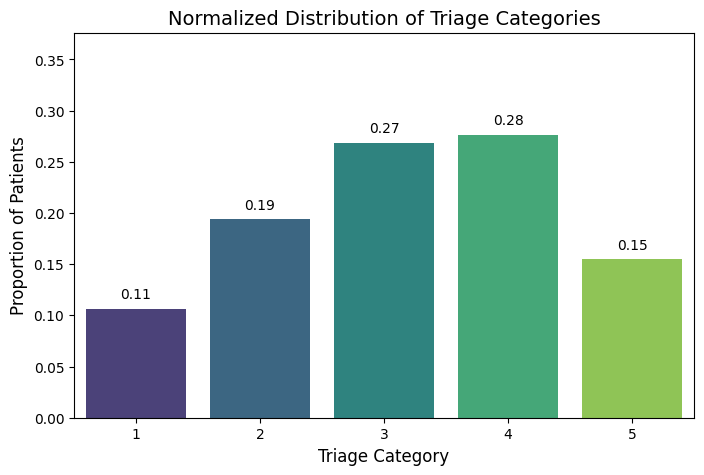

In [346]:
import matplotlib.pyplot as plt
import seaborn as sns

triage_counts = pd.Series(assigned_triage).value_counts(normalize=True).sort_index()
triage_levels = triage_counts.index.astype(str)
frequencies = triage_counts.values

plt.figure(figsize=(8, 5))
sns.barplot(x=triage_levels, y=frequencies, hue=triage_levels, palette="viridis", dodge=False, legend=False)

plt.xlabel('Triage Category', fontsize=12)
plt.ylabel('Proportion of Patients', fontsize=12)
plt.title('Normalized Distribution of Triage Categories', fontsize=14)

#Show proportion values on top of bars
for i, freq in enumerate(frequencies):
    plt.text(i, freq + 0.01, f'{freq:.2f}', ha='center', fontsize=10)
plt.ylim(0, max(frequencies) + 0.1)
plt.show()

4. Simulate diagnostic testing requirements with Bernoulli Trials

In [347]:
#probability of requiring diagn. testing - 30% is typical for clinical studies
diagnostic_probability = 0.3

In [348]:
# binary diagnostic requirement flags to patients
requires_diagnostics = np.random.binomial(n=1, p=diagnostic_probability, size=num_patients)

In [349]:
print(f"Percentage of patients requiring diagnostics: {requires_diagnostics.mean() * 100:.2f}%")

Percentage of patients requiring diagnostics: 29.82%


**5. Sample process durations using Triangular Distributions**

to avoid zero to negative values & return array of samples.

parameters:

*  minimum: minimum value of distribution
*  mode: most likely (peak) value
*  maximum: maximum value
*  sample_size: number of samples to generate

In [350]:
def triangular_sample(minimum, mode, maximum, sample_size):
  samples = np.random.triangular(left=minimum, mode=mode, right=maximum, size=sample_size)
  return np.clip(samples, a_min=0.1, a_max=None)  # ensures positive durations

In [351]:
# sample process durations in minutes for each patient

triage_times = triangular_sample(5, 10, 15, num_patients)
registration_times = triangular_sample(3, 7, 12, num_patients)
consultation_times = triangular_sample(15, 25, 40, num_patients)
diagnostic_times = triangular_sample(20, 30, 45, num_patients)
treatment_times = triangular_sample(10, 20, 35, num_patients)

In [352]:
# setting diagnostics to 0 for pations not requiring it
diagnostic_times *= requires_diagnostics

In [353]:
print("Sample of Consultation Times (minutes):")
for i, time in enumerate(consultation_times[:5], start=1):
    print(f"  Patient {i}: {time:.2f} minutes")

Sample of Consultation Times (minutes):
  Patient 1: 18.12 minutes
  Patient 2: 24.90 minutes
  Patient 3: 31.39 minutes
  Patient 4: 24.24 minutes
  Patient 5: 25.56 minutes


6. Gather generated variables into chronologically ordered dataset for further simulation (both control and manipulated scenarios)

In [354]:
ed_patient_data = pd.DataFrame({
    'arrival_time_hr': arrival_times,   #hours since simulation start
    'triage_category': assigned_triage,  #triage levels 1–5
    'requires_diagnostics': requires_diagnostics,   #booleans
    'triage_time_min': triage_times,  #continuous var-s, process durations in minutes
    'registration_time_min': registration_times,
    'consultation_time_min': consultation_times,
    'diagnostic_time_min': diagnostic_times,
    'treatment_time_min': treatment_times
})

In [355]:
#sort dataset by arrival time to ensure the correct event sequencing
ed_patient_data.sort_values('arrival_time_hr', inplace=True)
ed_patient_data.reset_index(drop=True, inplace=True)

In [356]:
# how the dataset looks like (what's stored inside, not easy to analyse)
print(ed_patient_data.head())

   arrival_time_hr  triage_category  requires_diagnostics  triage_time_min  \
0         0.032919                4                     0         9.234256   
1         0.055742                2                     0        10.856518   
2         0.059983                5                     1         8.466979   
3         0.064223                3                     0         8.095101   
4         0.065719                3                     1        12.978108   

   registration_time_min  consultation_time_min  diagnostic_time_min  \
0               5.492160              18.120811             0.000000   
1               7.590787              24.897107             0.000000   
2               6.266324              31.391903            42.557368   
3              10.333929              24.236401             0.000000   
4               9.144008              25.562853            28.585121   

   treatment_time_min  
0           20.133074  
1           28.833465  
2           28.762714  
3 

In [357]:
#sort and reset index
ed_patient_data.sort_values('arrival_time_hr', inplace=True)
ed_patient_data.reset_index(drop=True, inplace=True)
# verify with the previous one - compare
print(ed_patient_data.head())

   arrival_time_hr  triage_category  requires_diagnostics  triage_time_min  \
0         0.032919                4                     0         9.234256   
1         0.055742                2                     0        10.856518   
2         0.059983                5                     1         8.466979   
3         0.064223                3                     0         8.095101   
4         0.065719                3                     1        12.978108   

   registration_time_min  consultation_time_min  diagnostic_time_min  \
0               5.492160              18.120811             0.000000   
1               7.590787              24.897107             0.000000   
2               6.266324              31.391903            42.557368   
3              10.333929              24.236401             0.000000   
4               9.144008              25.562853            28.585121   

   treatment_time_min  
0           20.133074  
1           28.833465  
2           28.762714  
3 

In [358]:
print("Sample of Generated Patient Data (first 5 rows):\n")

# Select relevant columns for display
sample = ed_patient_data.head()

# Rename columns with descriptive headers for clarity
sample = sample.rename(columns={
    'arrival_time_hr': 'Arrival',
    'triage_category': 'TriageCat.',
    'requires_diagnostics': 'Needs Diagn.?',
    'triage_time_min': 'Triage(min)',
    'registration_time_min': 'Registr.(min)',
    'consultation_time_min': 'Consult.(min)',
    'diagnostic_time_min': 'Diagnostic(min)',
    'treatment_time_min': 'Treatment(min)'
})

print(sample.to_string(index=False))

Sample of Generated Patient Data (first 5 rows):

 Arrival  TriageCat.  Needs Diagn.?  Triage(min)  Registr.(min)  Consult.(min)  Diagnostic(min)  Treatment(min)
0.032919           4              0     9.234256       5.492160      18.120811         0.000000       20.133074
0.055742           2              0    10.856518       7.590787      24.897107         0.000000       28.833465
0.059983           5              1     8.466979       6.266324      31.391903        42.557368       28.762714
0.064223           3              0     8.095101      10.333929      24.236401         0.000000       24.143771
0.065719           3              1    12.978108       9.144008      25.562853        28.585121       27.727979


Visuals of the dataset by triage category

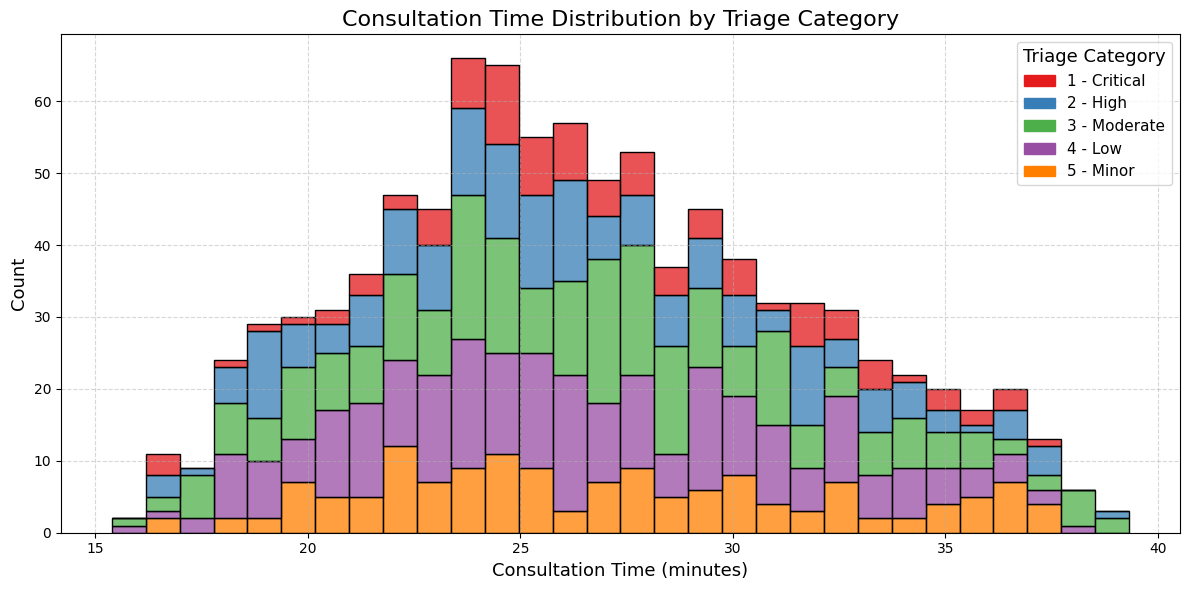

In [359]:
import matplotlib.patches as mpatches

palette = sns.color_palette("Set1", n_colors=5)


plot_data = ed_patient_data[['triage_category', 'consultation_time_min']].copy()
plot_data['triage_category'] = plot_data['triage_category'].astype('category')


plt.figure(figsize=(12, 6))
hist = sns.histplot(
    data=plot_data,
    x='consultation_time_min',
    hue='triage_category',
    multiple='stack',
    palette=palette,
    bins=30,
    edgecolor='black',
    alpha=0.75
)

plt.title('Consultation Time Distribution by Triage Category', fontsize=16)
plt.xlabel('Consultation Time (minutes)', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

triage_labels = ['1 - Critical', '2 - High', '3 - Moderate', '4 - Low', '5 - Minor']
handles = [mpatches.Patch(color=palette[i], label=triage_labels[i]) for i in range(len(triage_labels))]

plt.legend(handles=handles, title='Triage Category', title_fontsize=13, fontsize=11, loc='upper right')

plt.show()

# KPIs

Collect and store KPIs across simulations

In [360]:
class KPICollector:
    def __init__(self):
        self.waiting_times = []
        self.length_of_stay = []
        self.diverted_patients = 0
        self.doctor_busy_time = 0.0
        self.bed_busy_time = 0.0
        self.surgical_room_busy_time = 0.0
        self.diagnostic_room_busy_time = 0.0

    def reset(self):
        self.waiting_times.clear()
        self.length_of_stay.clear()
        self.diverted_patients = 0
        self.doctor_busy_time = 0.0
        self.bed_busy_time = 0.0
        self.surgical_room_busy_time = 0.0
        self.diagnostic_room_busy_time = 0.0

    def aggregate(self, other):
        self.waiting_times.extend(other.waiting_times)
        self.length_of_stay.extend(other.length_of_stay)
        self.diverted_patients += other.diverted_patients
        self.doctor_busy_time += other.doctor_busy_time
        self.bed_busy_time += other.bed_busy_time
        self.surgical_room_busy_time += other.surgical_room_busy_time
        self.diagnostic_room_busy_time += other.diagnostic_room_busy_time


In [361]:
from scipy import stats

In [362]:
def kpi_statistics(data):
    if len(data) == 0:
        return {'mean': None, 'median': None, 'mode': None, 'std_dev': None}
    mode_val = stats.mode(data, keepdims=False).mode
    return {
        'mean': np.mean(data),
        'median': np.median(data),
        'mode': mode_val,
        'std_dev': np.std(data, ddof=1)
    }

In [363]:
def utilization_stats(label, busy_time, capacity, sim_hours):
    utilization_pct = (busy_time / (capacity * sim_hours)) * 100
    print(f"{label}: {utilization_pct:.2f}% average utilization")

In [364]:
def print_resource_utilization(replication_results, scenario_name):
    num_replications = len(replication_results)

    total_doctor_busy = sum(res.doctor_busy_time for res in replication_results)
    total_bed_busy = sum(res.bed_busy_time for res in replication_results)
    total_surgical_busy = sum(res.surgical_room_busy_time for res in replication_results)
    total_diagnostic_busy = sum(res.diagnostic_room_busy_time for res in replication_results)

    print(f"\n{scenario_name} Resource Utilizations:")
    utilization_stats("Doctor Utilization", total_doctor_busy, DOCTOR_CAPACITY, SIM_TIME_HOURS * num_replications)
    utilization_stats("Bed Utilization", total_bed_busy, BED_CAPACITY, SIM_TIME_HOURS * num_replications)
    utilization_stats("Surgical Room Utilization", total_surgical_busy, SURGICAL_ROOM_CAPACITY, SIM_TIME_HOURS * num_replications)
    utilization_stats("Diagnostic Room Utilization", total_diagnostic_busy, DIAGNOSTIC_ROOM_CAPASITY, SIM_TIME_HOURS * num_replications)

In [365]:
def print_kpi_stats(label, stats):
    print(f"{label}:")
    print(f"  Mean   : {float(stats['mean']):.2f} hours")
    print(f"  Median : {float(stats['median']):.2f} hours")
    print(f"  Mode   : {float(stats['mode']):.2f} hours")
    print(f"  Std Dev: {float(stats['std_dev']):.2f} hours\n")


# Control scenario simulation

1. Setting the baseline scenario basic resources (including human resources) capacities and data assumptions

In [366]:
DOCTOR_CAPACITY = 4
BED_CAPACITY = 15
SURGICAL_ROOM_CAPACITY = 1
DIAGNOSTIC_ROOM_CAPASITY = 5

In [367]:
SIM_TIME_HOURS = 48 # two days simulation

## Patient process

journey of one patient within ED. Max steps are:


1. triage identification
2. registration *time resource
3. consultation *doctor, time resource
4. diagnostics *, doctor, capacity of diagnostical rooms/equipment, time resource
5. admission decision n possible treatment incl. surgery *bed + surgical room + doctor, time capacity



In [368]:
def patient_process(env, patient_id, patient_data, doctors, beds, diagnostic_rooms, surgical_rooms, kpi):

    arrival_time = patient_data.loc[patient_id, 'arrival_time_hr']
    #wait for arrival
    yield env.timeout(max(0, arrival_time - env.now))

    start_time = env.now

    # Triage identif. and registration(assumed unconstrained)
    yield env.timeout(patient_data.loc[patient_id, 'triage_time_min'] / 60)
    yield env.timeout(patient_data.loc[patient_id, 'registration_time_min'] / 60)

    #Consultation
    with doctors.request() as req:
        yield req
        wait_time = env.now - start_time
        kpi.waiting_times.append(wait_time)
        consult_duration = patient_data.loc[patient_id, 'consultation_time_min'] / 60
        kpi.doctor_busy_time += consult_duration
        yield env.timeout(consult_duration)

    # Diagnostics / if required
    if patient_data.loc[patient_id, 'requires_diagnostics'] == 1:
        with diagnostic_rooms.request() as req:
            yield req
            diag_duration = patient_data.loc[patient_id, 'diagnostic_time_min'] / 60
            kpi.diagnostic_room_busy_time += diag_duration
            yield env.timeout(diag_duration)

    # admission decision / (30% admitted)
    admitted = np.random.rand() < 0.3

    if admitted:
        # bed
        with beds.request() as bed_req:
            bed_result = yield bed_req | env.timeout(0)  # Non-blocking bed request
            if bed_req not in bed_result:
                # No beds => patient diverted
                kpi.diverted_patients += 1
                kpi.length_of_stay.append(env.now - start_time)
                return

            # decide boolean if surgery is needed /50% of admitted require surgery
            surgery_needed = np.random.rand() < 0.5

            if surgery_needed:
                with surgical_rooms.request() as surg_req:
                    yield surg_req
                    surgery_duration = patient_data.loc[patient_id, 'surgery_time_min'] / 60
                    kpi.surgical_room_busy_time += surgery_duration
                    yield env.timeout(surgery_duration)

            # treatment duration after surgery || treatment admitted non-surgical patients
            treatment_duration = patient_data.loc[patient_id, 'treatment_time_min'] / 60
            kpi.bed_busy_time += treatment_duration
            yield env.timeout(treatment_duration)

    else:
        # treatment - no bed or surgical room needed
        yield env.timeout(patient_data.loc[patient_id, 'treatment_time_min'] / 60)

    # total LOS
    kpi.length_of_stay.append(env.now - start_time)


Changes for initial dataframe to fit the patient process with ***surgery***

In [369]:
num_patients = len(ed_patient_data)

ed_patient_data['surgery_time_min'] = 0.0

# 50% require surgery
surgery_mask = np.random.binomial(1, 0.5, num_patients).astype(bool)

#TriangularDistribution for surgery time: min=60, mode=120, max=180 minutes
surgery_times = np.random.triangular(left=60, mode=120, right=180, size=num_patients)

# Assign surgery times only for patients selected for surgery
ed_patient_data.loc[surgery_mask, 'surgery_time_min'] = surgery_times[surgery_mask]

# Simulation function (will use also for manipulated *consitions* later)

In [370]:
def run_control_simulation(patient_data, run_time=SIM_TIME_HOURS):
    import simpy
    env = simpy.Environment()

    doctors = simpy.Resource(env, capacity=DOCTOR_CAPACITY)
    beds = simpy.Resource(env, capacity=BED_CAPACITY)
    surgical_rooms = simpy.Resource(env, capacity=SURGICAL_ROOM_CAPACITY)
    diagnostic_rooms = simpy.Resource(env, capacity=DIAGNOSTIC_ROOM_CAPASITY)

    kpi = KPICollector()

    for patient_id in patient_data.index:
        env.process(patient_process(env, patient_id, patient_data, doctors, beds, diagnostic_rooms, surgical_rooms, kpi))

    env.run(until=run_time)

    return kpi

Run simulation  10 times

In [371]:
num_replications = 10
replication_results = []

for i in range(num_replications):
    kpi = run_control_simulation(ed_patient_data, run_time=SIM_TIME_HOURS)
    replication_results.append(kpi)

#Aggregate KPIs from all replications
all_waiting_times = []
all_length_of_stay = []
total_diverted = 0

for res in replication_results:
    all_waiting_times.extend(res.waiting_times)
    all_length_of_stay.extend(res.length_of_stay)
    total_diverted += res.diverted_patients

# KPI statistics  on control scenario

In [372]:
# Calculate aggregated statistics
waiting_stats = kpi_statistics(all_waiting_times)
los_stats = kpi_statistics(all_length_of_stay)

In [373]:
print_kpi_stats("Aggregated Waiting Time Statistics", waiting_stats)
print_kpi_stats("Aggregated Length of Stay Statistics", los_stats)
print(f"Aggregated Total Diverted Patients: {total_diverted}\n")

Aggregated Waiting Time Statistics:
  Mean   : 18.90 hours
  Median : 19.11 hours
  Mode   : 0.25 hours
  Std Dev: 10.81 hours

Aggregated Length of Stay Statistics:
  Mean   : 19.93 hours
  Median : 20.62 hours
  Mode   : 0.88 hours
  Std Dev: 10.65 hours

Aggregated Total Diverted Patients: 154



In [374]:
print_resource_utilization(replication_results, "Control Scenario")


Control Scenario Resource Utilizations:
Doctor Utilization: 99.80% average utilization
Bed Utilization: 5.12% average utilization
Surgical Room Utilization: 93.71% average utilization
Diagnostic Room Utilization: 28.39% average utilization


# Manipulated 1 - fast track for minor cases

In [375]:
FAST_TRACK_DOCTOR_CAPACITY = 5

### patient process with a fast track

In [376]:
def patient_process_fast_track(env, patient_id, patient_data, doctors, beds, diagnostic_rooms, surgical_rooms, fast_track_doctors, kpi):
    arrival = patient_data.loc[patient_id, 'arrival_time_hr']
    yield env.timeout(max(0, arrival - env.now))

    start_time = env.now

    # Triage and registration
    yield env.timeout(patient_data.loc[patient_id, 'triage_time_min'] / 60)
    yield env.timeout(patient_data.loc[patient_id, 'registration_time_min'] / 60)

    triage_cat = patient_data.loc[patient_id, 'triage_category']

    # Doctor pool selection
    if triage_cat in [4, 5]:
        doctor_resource = fast_track_doctors
    else:
        doctor_resource = doctors

    # Consultation
    with doctor_resource.request() as req:
        yield req
        wait_time = env.now - start_time
        kpi.waiting_times.append(wait_time)
        duration = patient_data.loc[patient_id, 'consultation_time_min'] / 60
        kpi.doctor_busy_time += duration
        yield env.timeout(duration)

    # Diagnostics if needed
    if patient_data.loc[patient_id, 'requires_diagnostics'] == 1:
        with diagnostic_rooms.request() as req:
            yield req
            duration = patient_data.loc[patient_id, 'diagnostic_time_min'] / 60
            kpi.diagnostic_room_busy_time += duration
            yield env.timeout(duration)

    # Admission decision (30%)
    admitted = np.random.rand() < 0.3
    if admitted:
        with beds.request() as req:
            result = yield req | env.timeout(0)  # Non-blocking bed request
            if req not in result:
                kpi.diverted_patients += 1
                kpi.length_of_stay.append(env.now - start_time)
                return

            # Surgery decision for admitted patients (50% chance)
            surgery_needed = np.random.rand() < 0.5
            if surgery_needed:
                with surgical_rooms.request() as surg_req:
                    yield surg_req
                    surgery_duration = patient_data.loc[patient_id, 'surgery_time_min'] / 60
                    kpi.surgical_room_busy_time += surgery_duration
                    yield env.timeout(surgery_duration)

            # Treatment after surgery or admitted non-surgical patients
            treatment_duration = patient_data.loc[patient_id, 'treatment_time_min'] / 60
            kpi.bed_busy_time += treatment_duration
            yield env.timeout(treatment_duration)
    else:
        # Treatment without admission (no bed/surgery)
        yield env.timeout(patient_data.loc[patient_id, 'treatment_time_min'] / 60)

    kpi.length_of_stay.append(env.now - start_time)


### fast track sim runner

In [377]:
def run_fast_track_simulation(patient_data, run_time=SIM_TIME_HOURS):
    import simpy
    env = simpy.Environment()

    doctors = simpy.Resource(env, capacity=DOCTOR_CAPACITY)
    fast_track_doctors = simpy.Resource(env, capacity=FAST_TRACK_DOCTOR_CAPACITY)
    beds = simpy.Resource(env, capacity=BED_CAPACITY)
    surgical_rooms = simpy.Resource(env, capacity=SURGICAL_ROOM_CAPACITY)
    diagnostic_rooms = simpy.Resource(env, capacity=DIAGNOSTIC_ROOM_CAPASITY)

    kpi = KPICollector()

    for patient_id in patient_data.index:
        env.process(patient_process_fast_track(env, patient_id, patient_data, doctors, beds,
                                              diagnostic_rooms, surgical_rooms, fast_track_doctors, kpi))

    env.run(until=run_time)

    return kpi

In [378]:
num_replications = 10
replication_results_ft = []

for i in range(num_replications):
    kpi = run_fast_track_simulation(ed_patient_data, run_time=SIM_TIME_HOURS)
    replication_results_ft.append(kpi)

# KPI stats on scen1

In [379]:
all_waiting_times_ft = []
all_length_of_stay_ft = []
total_diverted_ft = 0

for res in replication_results_ft:
    all_waiting_times_ft.extend(res.waiting_times)
    all_length_of_stay_ft.extend(res.length_of_stay)
    total_diverted_ft += res.diverted_patients

In [380]:

waiting_stats_ft = kpi_statistics(all_waiting_times_ft)
los_stats_ft = kpi_statistics(all_length_of_stay_ft)


In [381]:
print_kpi_stats("Fast-Track Aggregated Waiting Time Statistics", waiting_stats_ft)
print_kpi_stats("Fast-Track Aggregated Length of Stay Statistics", los_stats_ft)
print(f"Fast-Track Aggregated Total Diverted Patients: {total_diverted_ft}\n")

Fast-Track Aggregated Waiting Time Statistics:
  Mean   : 10.76 hours
  Median : 8.94 hours
  Mode   : 0.21 hours
  Std Dev: 7.51 hours

Fast-Track Aggregated Length of Stay Statistics:
  Mean   : 11.92 hours
  Median : 10.16 hours
  Mode   : 0.88 hours
  Std Dev: 7.49 hours

Fast-Track Aggregated Total Diverted Patients: 1248



In [382]:
print_resource_utilization(replication_results, "Control Scenario")
print_resource_utilization(replication_results_ft, "Fast-Track Scenario")


Control Scenario Resource Utilizations:
Doctor Utilization: 99.80% average utilization
Bed Utilization: 5.12% average utilization
Surgical Room Utilization: 93.71% average utilization
Diagnostic Room Utilization: 28.39% average utilization

Fast-Track Scenario Resource Utilizations:
Doctor Utilization: 194.20% average utilization
Bed Utilization: 5.20% average utilization
Surgical Room Utilization: 99.61% average utilization
Diagnostic Room Utilization: 55.76% average utilization


# Manipulated scenario 2 - additional sugical room n diagnostical equipment

In [383]:
SCEN2_SURGICAL_ROOM_CAPACITY = 2 #+1
SCEN2_DIAGNOSTIC_ROOM_CAPACITY = 7 #+2
SCEN2_DOCTOR_CAPACITY = 5  #+1

## Patient process is the same as baseline

## runner of simulation function new to accumulate data

In [384]:
def run_scenario2_simulation(patient_data, run_time=SIM_TIME_HOURS):
    import simpy
    env = simpy.Environment()

    doctors = simpy.Resource(env, capacity=SCEN2_DOCTOR_CAPACITY)
    beds = simpy.Resource(env, capacity=BED_CAPACITY)  # no change to beds
    surgical_rooms = simpy.Resource(env, capacity=SCEN2_SURGICAL_ROOM_CAPACITY)
    diagnostic_rooms = simpy.Resource(env, capacity=SCEN2_DIAGNOSTIC_ROOM_CAPACITY)

    kpi = KPICollector()

    for patient_id in patient_data.index:
        env.process(patient_process(env, patient_id, patient_data, doctors, beds, diagnostic_rooms, surgical_rooms, kpi))

    env.run(until=run_time)

    return kpi


In [385]:
num_replications = 10
replication_results_scen2 = []

for i in range(num_replications):
    kpi = run_scenario2_simulation(ed_patient_data, run_time=SIM_TIME_HOURS)
    replication_results_scen2.append(kpi)

# Scen2 KPIs

In [386]:
all_waiting_times_s2 = []
all_length_of_stay_s2 = []
total_diverted_s2 = 0

for res in replication_results_scen2:
    all_waiting_times_s2.extend(res.waiting_times)
    all_length_of_stay_s2.extend(res.length_of_stay)
    total_diverted_s2 += res.diverted_patients

In [387]:
waiting_stats_s2 = kpi_statistics(all_waiting_times_s2)
los_stats_s2 = kpi_statistics(all_length_of_stay_s2)

In [388]:

print_kpi_stats("Scenario 2 Aggregated Waiting Time Statistics", waiting_stats_s2)
print_kpi_stats("Scenario 2 Aggregated Length of Stay Statistics", los_stats_s2)
print(f"Scenario 2 Aggregated Total Diverted Patients: {total_diverted_s2}\n")

Scenario 2 Aggregated Waiting Time Statistics:
  Mean   : 17.49 hours
  Median : 17.43 hours
  Mode   : 0.22 hours
  Std Dev: 9.92 hours

Scenario 2 Aggregated Length of Stay Statistics:
  Mean   : 18.19 hours
  Median : 18.06 hours
  Mode   : 0.88 hours
  Std Dev: 9.72 hours

Scenario 2 Aggregated Total Diverted Patients: 22



In [389]:
print_resource_utilization(replication_results_scen2, "Scenario 2")


Scenario 2 Resource Utilizations:
Doctor Utilization: 125.00% average utilization
Bed Utilization: 7.69% average utilization
Surgical Room Utilization: 160.84% average utilization
Diagnostic Room Utilization: 33.46% average utilization


In [390]:
print_resource_utilization(replication_results, "Control Scenario")
print_resource_utilization(replication_results_ft, "Fast-Track Scenario")


Control Scenario Resource Utilizations:
Doctor Utilization: 99.80% average utilization
Bed Utilization: 5.12% average utilization
Surgical Room Utilization: 93.71% average utilization
Diagnostic Room Utilization: 28.39% average utilization

Fast-Track Scenario Resource Utilizations:
Doctor Utilization: 194.20% average utilization
Bed Utilization: 5.20% average utilization
Surgical Room Utilization: 99.61% average utilization
Diagnostic Room Utilization: 55.76% average utilization


# Manipulated Scenario 3 - mixed

parameters are set again (not to forget, plus can do them const above)

In [400]:
SCEN2_SURGICAL_ROOM_CAPACITY = 2
SCEN2_DIAGNOSTIC_ROOM_CAPACITY = 7
SCEN2_DOCTOR_CAPACITY = 5
FAST_TRACK_DOCTOR_CAPACITY = 5     #from scen1, fast track doctors
BED_CAPACITY = 15

In [401]:
def run_scenario3_simulation(patient_data, run_time=SIM_TIME_HOURS):
    env = simpy.Environment()

    doctors = simpy.Resource(env, capacity=SCEN2_DOCTOR_CAPACITY)
    fast_track_doctors = simpy.Resource(env, capacity=FAST_TRACK_DOCTOR_CAPACITY)
    beds = simpy.Resource(env, capacity=BED_CAPACITY)
    surgical_rooms = simpy.Resource(env, capacity=SCEN2_SURGICAL_ROOM_CAPACITY)
    diagnostic_rooms = simpy.Resource(env, capacity=SCEN2_DIAGNOSTIC_ROOM_CAPACITY)

    kpi = KPICollector()

    for patient_id in patient_data.index:
        env.process(patient_process_fast_track(env, patient_id, patient_data,
                                              doctors, beds, diagnostic_rooms,
                                              surgical_rooms, fast_track_doctors, kpi))

    env.run(until=run_time)

    return kpi


In [402]:

num_replications = 10
replication_results_s3 = []

for i in range(num_replications):
    kpi = run_scenario3_simulation(ed_patient_data, run_time=SIM_TIME_HOURS)
    replication_results_s3.append(kpi)


In [403]:

all_waiting_times_s3 = []
all_length_of_stay_s3 = []
total_diverted_s3 = 0

In [395]:
for res in replication_results_s3:
    all_waiting_times_s3.extend(res.waiting_times)
    all_length_of_stay_s3.extend(res.length_of_stay)
    total_diverted_s3 += res.diverted_patients

# KPIs scen3 mixed

In [396]:
waiting_stats_s3 = kpi_statistics(all_waiting_times_s3)
los_stats_s3 = kpi_statistics(all_length_of_stay_s3)


In [397]:
print_kpi_stats("Scenario 3 Aggregated Waiting Time Statistics", waiting_stats_s3)
print_kpi_stats("Scenario 3 Aggregated Length of Stay Statistics", los_stats_s3)
print(f"Scenario 3 Aggregated Total Diverted Patients: {total_diverted_s3}\n")

Scenario 3 Aggregated Waiting Time Statistics:
  Mean   : 9.87 hours
  Median : 8.89 hours
  Mode   : 0.21 hours
  Std Dev: 6.38 hours

Scenario 3 Aggregated Length of Stay Statistics:
  Mean   : 11.02 hours
  Median : 10.12 hours
  Mode   : 0.88 hours
  Std Dev: 6.30 hours

Scenario 3 Aggregated Total Diverted Patients: 865



In [398]:

print_resource_utilization(replication_results_s3, "Scenario 3")



Scenario 3 Resource Utilizations:
Doctor Utilization: 219.00% average utilization
Bed Utilization: 9.35% average utilization
Surgical Room Utilization: 194.84% average utilization
Diagnostic Room Utilization: 62.17% average utilization


In [399]:
print_resource_utilization(replication_results, "Control Scenario")
print_resource_utilization(replication_results_ft, "Fast-Track Scenario")
print_resource_utilization(replication_results_scen2, "Scenario 2")


Control Scenario Resource Utilizations:
Doctor Utilization: 99.80% average utilization
Bed Utilization: 5.12% average utilization
Surgical Room Utilization: 93.71% average utilization
Diagnostic Room Utilization: 28.39% average utilization

Fast-Track Scenario Resource Utilizations:
Doctor Utilization: 194.20% average utilization
Bed Utilization: 5.20% average utilization
Surgical Room Utilization: 99.61% average utilization
Diagnostic Room Utilization: 55.76% average utilization

Scenario 2 Resource Utilizations:
Doctor Utilization: 125.00% average utilization
Bed Utilization: 7.69% average utilization
Surgical Room Utilization: 160.84% average utilization
Diagnostic Room Utilization: 33.46% average utilization


# ----------------------------------------

# KPIs summary

# Stats summary

# Visualisation and comparison  of the scenarios (and versus control)